In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, optimizers
from keras.layers import Dropout, Flatten, Dense, Reshape, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import DepthwiseConv2D, LSTM, GRU, TimeDistributed, Conv2D, GlobalAveragePooling2D, Dense, Bidirectional, MultiHeadAttention, Attention


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project

/content/drive/MyDrive/project


In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [4]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)

    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)


    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    X = X[:,:,0:600]
    print('Shape of X after trimming:',X.shape)

    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X


########################################################################

def segment_data_by_subject(x_test, y_test, person_test):
    x_test_by_subject = defaultdict(list)
    y_test_by_subject = defaultdict(list)

    for i, subject_id_array in enumerate(person_test):
        subject_id = int(subject_id_array[0])
        x_test_by_subject[subject_id].append(x_test[i])
        y_test_by_subject[subject_id].append(y_test[i])

    for subject_id in x_test_by_subject:
        x_test_by_subject[subject_id] = np.array(x_test_by_subject[subject_id])
        y_test_by_subject[subject_id] = np.array(y_test_by_subject[subject_id])

    return x_test_by_subject, y_test_by_subject


def evaluate_and_plot(model, x_test_by_subject, y_test_by_subject):
    subject_accuracies = {}

    for subject_id in sorted(x_test_by_subject.keys()):
        x_test_subject = x_test_by_subject[subject_id]
        y_test_subject = y_test_by_subject[subject_id]

        test_loss, test_accuracy = model.evaluate(x_test_subject, y_test_subject, verbose=0)
        subject_accuracies[subject_id] = test_accuracy

        print(f"Subject {subject_id + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    subject_ids = [subject_id + 1 for subject_id in sorted(subject_accuracies)]
    accuracies = [subject_accuracies[subject_id] for subject_id in sorted(subject_accuracies)]

    plt.figure(figsize=(10, 6))
    plt.bar(subject_ids, accuracies, color='skyblue')
    plt.xlabel('Subject ID', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Model Accuracy by Subject', fontsize=16)
    plt.xticks(subject_ids)
    plt.ylim(0, 1)

    for i, acc in enumerate(accuracies):
        plt.text(subject_ids[i], acc, f"{acc:.2f}", ha='center', va='bottom')

    plt.show()



def prepare_training_data_for_subject(X, y, person_train, subject_id=0, sub_sample=2, average=2, noise=True):

    x_train_by_subject, y_train_by_subject = segment_data_by_subject(X, y, person_train)


    x_train_subject = x_train_by_subject[subject_id]
    y_train_subject = y_train_by_subject[subject_id]

    x_train_prepared, y_train_prepared = train_data_prep(x_train_subject, y_train_subject, sub_sample, average, noise)

    return x_train_prepared, y_train_prepared

In [5]:
y_train_valid -= 769
y_test -= 769
X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test)


ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification


y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

if y_test.ndim == 1 or y_test.shape[1] != 4:
    y_test = to_categorical(y_test, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


#Subject based
print('############################')

x_train_valid_sub1, y_train_valid_sub1 = prepare_training_data_for_subject(X_train_valid, y_train_valid, person_train_valid)

x_test_by_subject, y_test_by_subject = segment_data_by_subject(x_test, y_test, person_test)


num_samples = len(x_train_valid_sub1)  # Total number of samples after preprocessing
num_validation_samples = int(1000/8460 * num_samples)  # 20% of the total number of samples

ind_valid_sub1 = np.random.choice(num_samples, num_validation_samples, replace=False)
ind_train_sub1 = np.array(list(set(range(len(x_train_valid_sub1))).difference(set(ind_valid_sub1))))

x_train_sub1 = x_train_valid_sub1[ind_train_sub1]
y_train_sub1 = y_train_valid_sub1[ind_train_sub1]
x_valid_sub1 = x_train_valid_sub1[ind_valid_sub1]
y_valid_sub1 = y_train_valid_sub1[ind_valid_sub1]

y_train_sub1 = to_categorical(y_train_sub1, 4)
y_valid_sub1 = to_categorical(y_valid_sub1, 4)

x_train_sub1 = x_train_sub1.reshape(x_train_sub1.shape[0], x_train_sub1.shape[1], x_train_sub1.shape[2], 1)
x_valid_sub1 = x_valid_sub1.reshape(x_valid_sub1.shape[0], x_valid_sub1.shape[1], x_valid_sub1.shape[2], 1)

x_train_sub1 = np.swapaxes(x_train_sub1, 1, 3)
x_train_sub1 = np.swapaxes(x_train_sub1, 1, 2)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 3)
x_valid_sub1 = np.swapaxes(x_valid_sub1, 1, 2)

print('Shape of subject 1 training set:', x_train_sub1.shape)
print('Shape of subject 1 validation set:', x_valid_sub1.shape)
print('Shape of subject 1 training labels:', y_train_sub1.shape)
print('Shape of subject 1 validation labels:', y_valid_sub1.shape)

Shape of X after trimming: (2115, 22, 600)
Shape of X after maxpooling: (2115, 22, 300)
Shape of X after averaging+noise and concatenating: (4230, 22, 300)
Shape of X after subsampling and concatenating: (8460, 22, 300)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 600)
Shape of X after maxpooling: (443, 22, 300)
Shape of training set: (7460, 22, 300)
Shape of validation set: (1000, 22, 300)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 300, 1)
Shape of validation set after adding width info: (1000, 22, 300, 1)
Shape of test set after adding width info: (443, 22, 300, 1)
Shape of training set after dimension reshaping: (7460, 300, 1, 22)
Shape of validation set after dimension reshaping: (1000, 300, 1, 22)

In [6]:
x_train_reduced = np.squeeze(x_train, axis=2)
x_valid_reduced = np.squeeze(x_valid, axis=2)
x_test_reduced = np.squeeze(x_test, axis=2)

x_test_reduced_by_subject = {}
for subject_id, x_data in x_test_by_subject.items():
    # Apply squeeze operation to each subject's x_test data
    x_test_reduced_by_subject[subject_id] = np.squeeze(x_data, axis=2)


print('Shape of training set after reduction:', x_train_reduced.shape)
print('Shape of validation set after reduction:', x_valid_reduced.shape)
print('Shape of testing set after reduction:', x_test_reduced.shape)

Shape of training set after reduction: (7460, 300, 22)
Shape of validation set after reduction: (1000, 300, 22)
Shape of testing set after reduction: (443, 300, 22)


In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
from keras.layers import Bidirectional

**RNN(LSTM)**

In [9]:
(x_train_lstm, x_valid_lstm) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train_lstm, y_valid_lstm) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train_lstm.shape)
print('Shape of validation set:',x_valid_lstm.shape)
print('Shape of training labels:',y_train_lstm.shape)
print('Shape of validation labels:',y_valid_lstm.shape)
y_train_lstm = to_categorical(y_train_lstm, 4)
y_valid_lstm = to_categorical(y_valid_lstm, 4)
x_test_lstm = X_test_prep
y_test_lstm = y_test
print('Shape of test set:',x_test_lstm.shape)
print('Shape of test labels:',y_test_lstm.shape)

if y_test_lstm.ndim == 1 or y_test_lstm.shape[1] != 4:
    y_test_lstm = to_categorical(y_test_lstm, 4)

print('Shape of training labels after categorical conversion:',y_train_lstm.shape)
print('Shape of validation labels after categorical conversion:',y_valid_lstm.shape)
print('Shape of test labels after categorical conversion:',y_test_lstm.shape)
# (x_train_lstm_sub1, x_valid_lstm_sub1) = x_train_sub1[ind_train], x_valid_sub1[ind_valid]
# (y_train_lstm_sub1, y_valid_lstm_sub1) = y_train_sub1[ind_train], y_valid_sub1[ind_valid]
# print('Shape of subject 1 training set:',x_train_lstm_sub1.shape)
# print('Shape of subject 1 validation set:',x_valid_lstm_sub1.shape)
# print('Shape of subject 1 training labels:',y_train_lstm_sub1.shape)
# print('Shape of subject 1 validation labels:',y_valid_lstm_sub1.shape)



Shape of training set: (7460, 22, 300)
Shape of validation set: (1000, 22, 300)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of test set: (443, 22, 300)
Shape of test labels: (443, 4)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)


In [ ]:
X_train_valid_lstm_prep,y_train_valid_lstm_prep = train_data_prep(x_train_valid_sub1,y_train_valid_sub1,2,2,True)
x_train_lstm_sub1 = x_train_valid_sub1[ind_train_sub1]
y_train_lstm_sub1 = y_train_valid_sub1[ind_train_sub1]
x_valid_lstm_sub1 = x_train_valid_sub1[ind_valid_sub1]
y_valid_lstm_sub1 = y_train_valid_sub1[ind_valid_sub1]

In [10]:
pure_lstm_model = Sequential()
pure_lstm_model.add(Flatten())
pure_lstm_model.add(Dense(40))
pure_lstm_model.add(Reshape((40, 1)))
pure_lstm_model.add(Bidirectional(LSTM(10, input_shape=(None,22,300), activation = 'elu', return_sequences=True)))
pure_lstm_model.add(Dropout(0.2))

pure_lstm_model.add(Bidirectional(LSTM(10, activation = 'elu')))
pure_lstm_model.add(Dropout(0.2))
pure_lstm_model.add(Dense(4, activation='softmax'))


In [46]:
pure_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6600)              0         
                                                                 
 dense (Dense)               (None, 40)                264040    
                                                                 
 reshape (Reshape)           (None, 40, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 40, 20)            960       
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 40, 20)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                2480      
 onal)                                                  

In [11]:
learning_rate = 1e-3
epochs = 100
pure_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
early_stopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
pure_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=pure_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
pure_lstm_model_results = pure_lstm_model.fit(x_train_lstm,
             y_train_lstm,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_lstm, y_valid_lstm), verbose=True, callbacks=[early_stopping])

Epoch 1/100
117/117 [==============================] - 26s 155ms/step - loss: 1.8077 - accuracy: 0.2614 - val_loss: 1.3876 - val_accuracy: 0.3090
Epoch 2/100
117/117 [==============================] - 17s 149ms/step - loss: 1.4022 - accuracy: 0.2894 - val_loss: 1.3764 - val_accuracy: 0.3160
Epoch 3/100
117/117 [==============================] - 18s 150ms/step - loss: 1.3672 - accuracy: 0.3131 - val_loss: 1.3422 - val_accuracy: 0.3530
Epoch 4/100
117/117 [==============================] - 17s 149ms/step - loss: 1.3476 - accuracy: 0.3422 - val_loss: 1.3100 - val_accuracy: 0.3890
Epoch 5/100
117/117 [==============================] - 17s 149ms/step - loss: 1.3628 - accuracy: 0.3595 - val_loss: 1.3335 - val_accuracy: 0.3580
Epoch 6/100
117/117 [==============================] - 18s 152ms/step - loss: 1.3472 - accuracy: 0.3507 - val_loss: 1.2934 - val_accuracy: 0.4130
Epoch 7/100
117/117 [==============================] - 18s 151ms/step - loss: 1.3061 - accuracy: 0.3865 - val_loss: 1.2842 -

In [12]:
pure_lstm_score = pure_lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=0)
print('Test accuracy of the pure LSTM model:',pure_lstm_score[1])

Test accuracy of the pure LSTM model: 0.4762979745864868


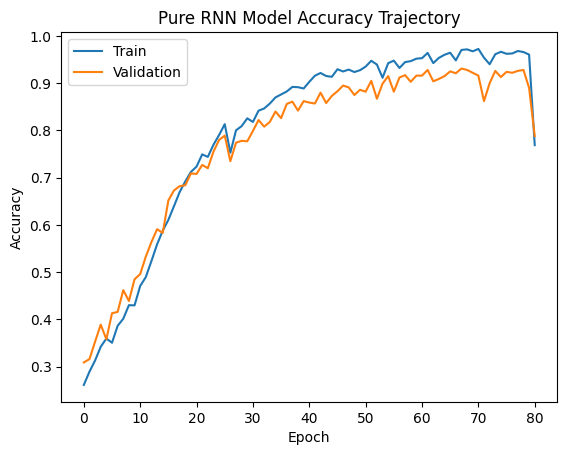

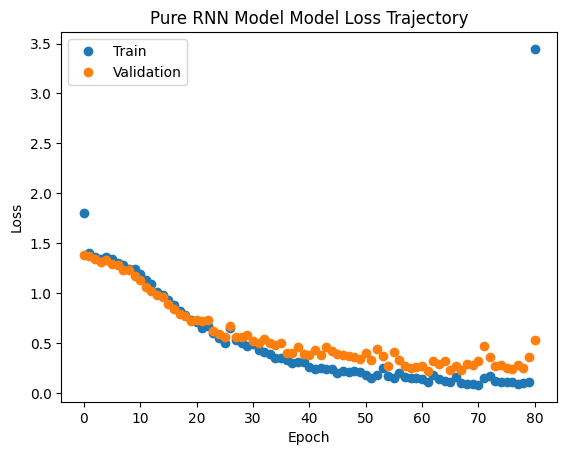

14/14 [==============================] - 0s 30ms/step - loss: 5.3502 - accuracy: 0.4763
Test Loss: 5.350210666656494
Test Accuracy: 0.4762979745864868


In [15]:
plt.plot(pure_lstm_model_results.history['accuracy'])
plt.plot(pure_lstm_model_results.history['val_accuracy'])
plt.title('Pure RNN Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(pure_lstm_model_results.history['loss'], 'o')
plt.plot(pure_lstm_model_results.history['val_loss'], 'o')
plt.title('Pure RNN Model Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = pure_lstm_model.evaluate(x_test_lstm, y_test_lstm, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Subject 1 - Test Loss: 8.9656, Test Accuracy: 0.3600
Subject 2 - Test Loss: 5.9701, Test Accuracy: 0.3800
Subject 3 - Test Loss: 4.1757, Test Accuracy: 0.4400
Subject 4 - Test Loss: 4.3434, Test Accuracy: 0.5400
Subject 5 - Test Loss: 4.4995, Test Accuracy: 0.5319
Subject 6 - Test Loss: 5.8061, Test Accuracy: 0.4898
Subject 7 - Test Loss: 2.7052, Test Accuracy: 0.6600
Subject 8 - Test Loss: 7.2709, Test Accuracy: 0.4000
Subject 9 - Test Loss: 4.3111, Test Accuracy: 0.4894


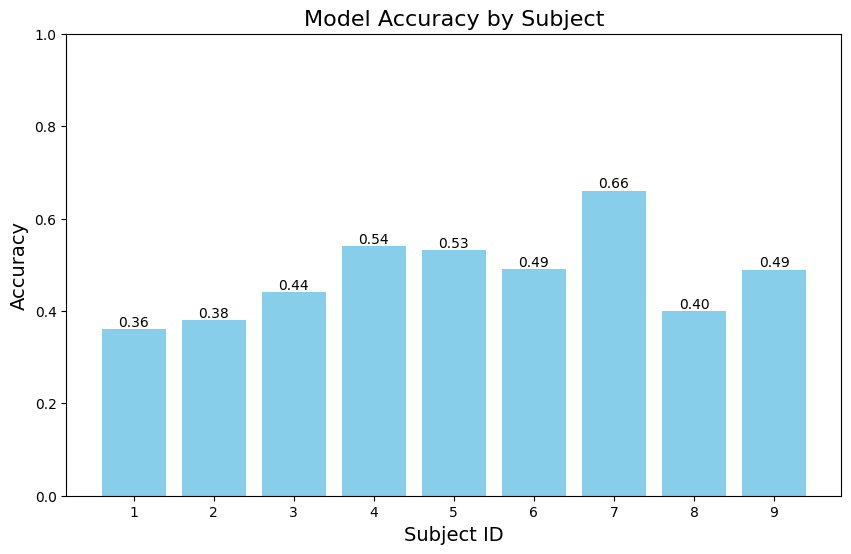

In [29]:
x_test_lstm_by_subject, y_test_lstm_by_subject = segment_data_by_subject(x_test_lstm, y_test_lstm, person_test)
evaluate_and_plot(pure_lstm_model, x_test_lstm_by_subject, y_test_lstm_by_subject)

In [38]:

x_train_lstm_sub1 = x_train_sub1.reshape(x_train_sub1.shape[0], x_train_sub1.shape[3], x_train_sub1.shape[1] * x_train_sub1.shape[2])
x_valid_lstm_sub1 = x_valid_sub1.reshape(x_valid_sub1.shape[0], x_valid_sub1.shape[3], x_valid_sub1.shape[1] * x_valid_sub1.shape[2])
y_train_lstm_sub1 = y_train_sub1
y_valid_lstm_sub1 = y_valid_sub1
print(x_train_lstm_sub1.shape)
print(x_valid_lstm_sub1.shape)
print(y_train_lstm_sub1.shape)
print(y_valid_lstm_sub1.shape)

(836, 22, 300)
(112, 22, 300)
(836, 4)
(112, 4)


In [41]:
rnn_optimize1 = Sequential()
rnn_optimize1.add(Flatten())
rnn_optimize1.add(Dense(40))
rnn_optimize1.add(Reshape((40, 1)))
rnn_optimize1.add(Bidirectional(LSTM(10, input_shape=(None,22,300), activation = 'elu', return_sequences=True)))
rnn_optimize1.add(Dropout(0.2))

rnn_optimize1.add(Bidirectional(LSTM(10, activation = 'elu')))
rnn_optimize1.add(Dropout(0.2))
rnn_optimize1.add(Dense(4, activation='softmax'))

In [44]:
earning_rate = 1e-3
epochs = 300
pure_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
early_stopping = EarlyStopping(monitor='accuracy', patience=25, verbose=1, mode='max', restore_best_weights=True)
rnn_optimize1.compile(loss='categorical_crossentropy',
                 optimizer=pure_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
rnn_optimize1_results = rnn_optimize1.fit(x_train_lstm_sub1,
             y_train_lstm_sub1,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_lstm_sub1, y_valid_lstm_sub1), verbose=True, callbacks=[early_stopping])

Epoch 1/300
14/14 [==============================] - 7s 194ms/step - loss: 1.1807 - accuracy: 0.4821 - val_loss: 1.0402 - val_accuracy: 0.5714
Epoch 2/300
14/14 [==============================] - 2s 158ms/step - loss: 1.2040 - accuracy: 0.4761 - val_loss: 1.0848 - val_accuracy: 0.5446
Epoch 3/300
14/14 [==============================] - 2s 146ms/step - loss: 1.1509 - accuracy: 0.4904 - val_loss: 0.9924 - val_accuracy: 0.5982
Epoch 4/300
14/14 [==============================] - 2s 154ms/step - loss: 1.1532 - accuracy: 0.5167 - val_loss: 1.0303 - val_accuracy: 0.5089
Epoch 5/300
14/14 [==============================] - 2s 157ms/step - loss: 1.1005 - accuracy: 0.5514 - val_loss: 0.9360 - val_accuracy: 0.6339
Epoch 6/300
14/14 [==============================] - 2s 163ms/step - loss: 1.0739 - accuracy: 0.5610 - val_loss: 0.9565 - val_accuracy: 0.5804
Epoch 7/300
14/14 [==============================] - 2s 161ms/step - loss: 0.9777 - accuracy: 0.5957 - val_loss: 0.8908 - val_accuracy: 0.6429

Subject 1 - Test Loss: 2.8682, Test Accuracy: 0.2600
Subject 2 - Test Loss: 2.7315, Test Accuracy: 0.2200
Subject 3 - Test Loss: 2.8889, Test Accuracy: 0.3000
Subject 4 - Test Loss: 2.4350, Test Accuracy: 0.2400
Subject 5 - Test Loss: 2.1801, Test Accuracy: 0.3191
Subject 6 - Test Loss: 2.6186, Test Accuracy: 0.2857
Subject 7 - Test Loss: 2.3425, Test Accuracy: 0.2800
Subject 8 - Test Loss: 2.8514, Test Accuracy: 0.1600
Subject 9 - Test Loss: 2.2038, Test Accuracy: 0.2766


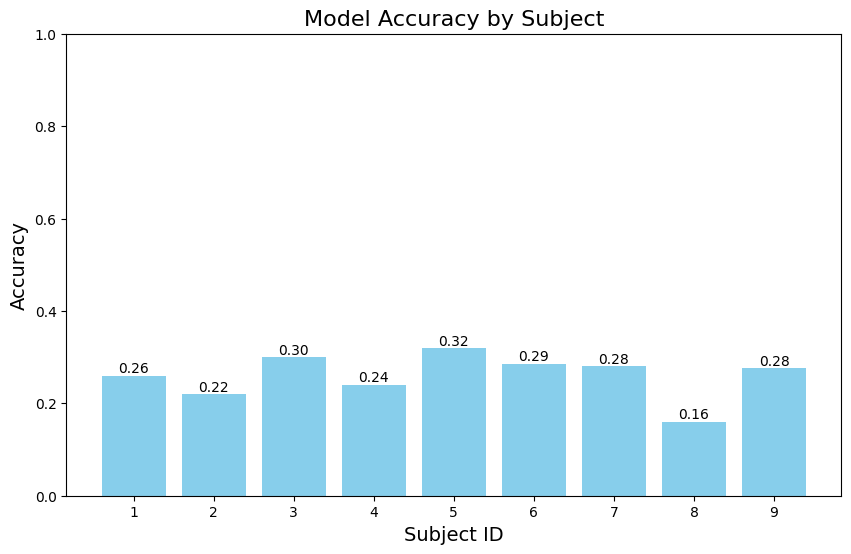

In [45]:
evaluate_and_plot(rnn_optimize1, x_test_lstm_by_subject, y_test_lstm_by_subject)

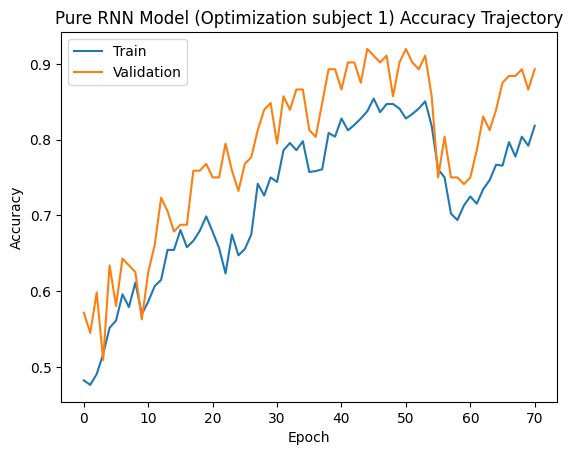

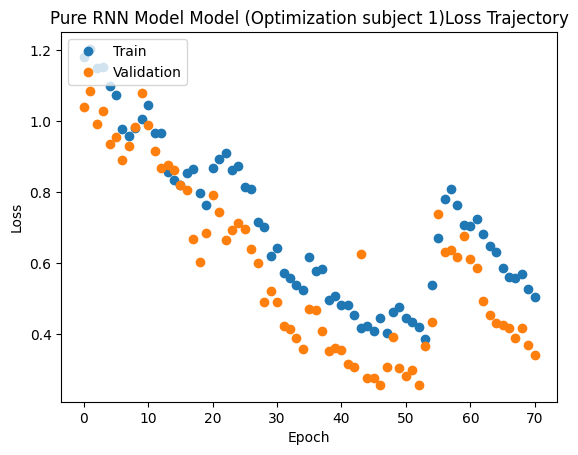

14/14 [==============================] - 0s 23ms/step - loss: 2.5739 - accuracy: 0.2596
Test Loss: 2.5738861560821533
Test Accuracy: 0.259593665599823


In [51]:
plt.plot(rnn_optimize1_results.history['accuracy'])
plt.plot(rnn_optimize1_results.history['val_accuracy'])
plt.title('Pure RNN Model (Optimization subject 1) Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_optimize1_results.history['loss'], 'o')
plt.plot(rnn_optimize1_results.history['val_loss'], 'o')
plt.title('Pure RNN Model Model (Optimization subject 1)Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = rnn_optimize1.evaluate(x_test_lstm, y_test_lstm, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

**CNN + Depthwise + LSTM**

In [25]:
hybrid_model = Sequential()
l2_reg = regularizers.l2(0.002)
# Conv. block 1
hybrid_model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='elu', input_shape=(300,1,22), kernel_regularizer=l2_reg))
hybrid_model.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.6))

# Conv. block 2
hybrid_model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.6))

# Conv. block 3
hybrid_model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.6))

# Conv. block 4
hybrid_model.add(Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model.add(BatchNormalization())
hybrid_model.add(Dropout(0.6))

#FC+LSTM layers
hybrid_model.add(Flatten())
hybrid_model.add(Dense(40))
hybrid_model.add(Reshape((40, 1)))
hybrid_model.add(Bidirectional(LSTM(10, dropout=0.4, recurrent_dropout=0.1, return_sequences=False)))
hybrid_model.add(Dense(4, activation='softmax'))

hybrid_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 300, 1, 32)        17632     
                                                                 
 depthwise_conv2d_4 (Depthw  (None, 300, 1, 64)        64        
 iseConv2D)                                                      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 100, 1, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 100, 1, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 100, 1, 64)        0         
                                                      

In [26]:
learning_rate = 1e-3
epochs = 100
hybrid_model_optimizer = keras.optimizers.Adam(lr=learning_rate)
early_stopping = EarlyStopping(monitor='accuracy', patience=20, verbose=1, mode='max', restore_best_weights=True)
hybrid_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_model_results = hybrid_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True, callbacks=[early_stopping])

Epoch 1/100
117/117 [==============================] - 32s 202ms/step - loss: 1.5937 - accuracy: 0.3575 - val_loss: 1.6108 - val_accuracy: 0.2570
Epoch 2/100
117/117 [==============================] - 23s 194ms/step - loss: 1.4383 - accuracy: 0.4586 - val_loss: 1.7100 - val_accuracy: 0.2560
Epoch 3/100
117/117 [==============================] - 22s 192ms/step - loss: 1.3924 - accuracy: 0.5079 - val_loss: 1.6120 - val_accuracy: 0.3680
Epoch 4/100
117/117 [==============================] - 22s 192ms/step - loss: 1.3680 - accuracy: 0.5420 - val_loss: 1.4009 - val_accuracy: 0.5410
Epoch 5/100
117/117 [==============================] - 23s 193ms/step - loss: 1.3377 - accuracy: 0.5637 - val_loss: 1.3003 - val_accuracy: 0.6120
Epoch 6/100
117/117 [==============================] - 22s 190ms/step - loss: 1.3101 - accuracy: 0.6016 - val_loss: 1.2098 - val_accuracy: 0.6650
Epoch 7/100
117/117 [==============================] - 23s 193ms/step - loss: 1.2901 - accuracy: 0.6139 - val_loss: 1.1990 -

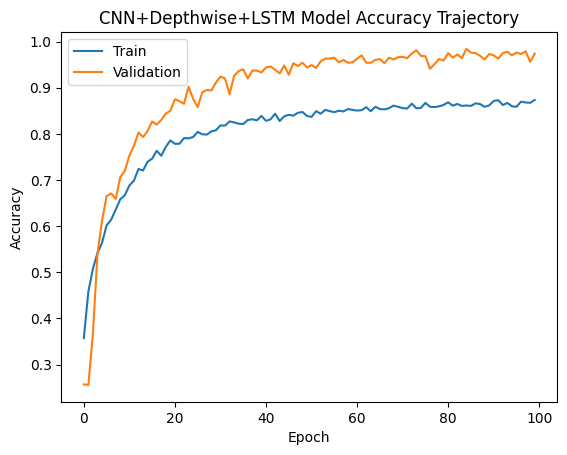

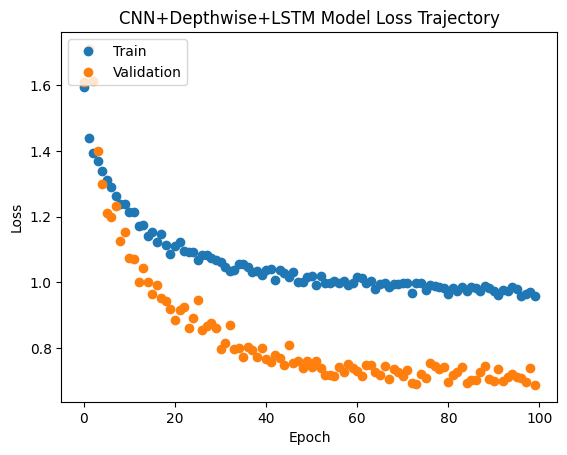

14/14 [==============================] - 0s 27ms/step - loss: 1.4658 - accuracy: 0.7065
Test Loss: 1.4657678604125977
Test Accuracy: 0.7065462470054626


In [27]:
plt.plot(hybrid_model_results.history['accuracy'])
plt.plot(hybrid_model_results.history['val_accuracy'])
plt.title('CNN+Depthwise+LSTM Model Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_model_results.history['loss'], 'o')
plt.plot(hybrid_model_results.history['val_loss'], 'o')
plt.title('CNN+Depthwise+LSTM Model Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = hybrid_model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Subject 1 - Test Loss: 2.0169, Test Accuracy: 0.5200
Subject 2 - Test Loss: 2.0194, Test Accuracy: 0.6000
Subject 3 - Test Loss: 1.6156, Test Accuracy: 0.7400
Subject 4 - Test Loss: 1.4596, Test Accuracy: 0.7000
Subject 5 - Test Loss: 1.5478, Test Accuracy: 0.8085
Subject 6 - Test Loss: 1.5598, Test Accuracy: 0.7347
Subject 7 - Test Loss: 1.5391, Test Accuracy: 0.6800
Subject 8 - Test Loss: 1.5505, Test Accuracy: 0.7200
Subject 9 - Test Loss: 1.2576, Test Accuracy: 0.7872


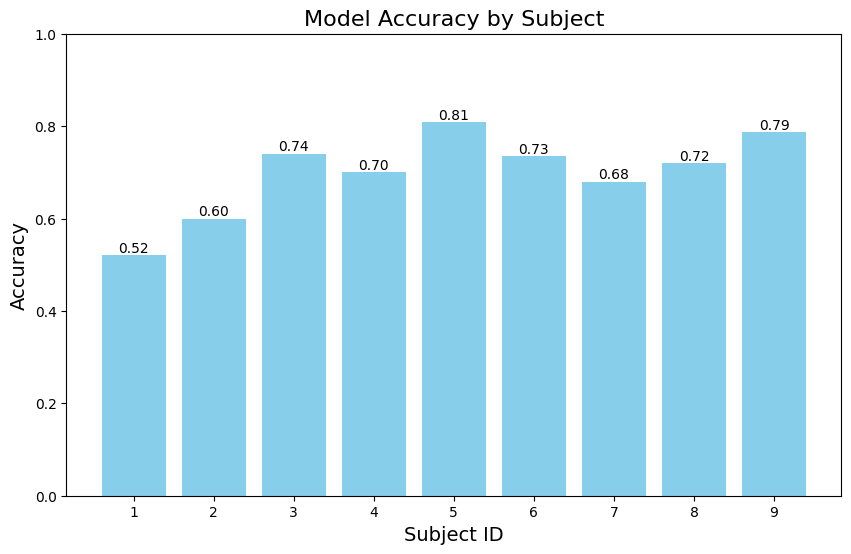

In [ ]:
evaluate_and_plot(hybrid_model, x_test_by_subject, y_test_by_subject)

In [49]:
hybrid_model_optimizeSub1 = Sequential()
l2_reg = regularizers.l2(0.002)
# Conv. block 1
hybrid_model_optimizeSub1.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='elu', input_shape=(300,1,22), kernel_regularizer=l2_reg))
hybrid_model_optimizeSub1.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model_optimizeSub1.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_model_optimizeSub1.add(BatchNormalization())
hybrid_model_optimizeSub1.add(Dropout(0.6))

# Conv. block 2
hybrid_model_optimizeSub1.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model_optimizeSub1.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model_optimizeSub1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model_optimizeSub1.add(BatchNormalization())
hybrid_model_optimizeSub1.add(Dropout(0.6))

# Conv. block 3
hybrid_model_optimizeSub1.add(Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model_optimizeSub1.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model_optimizeSub1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model_optimizeSub1.add(BatchNormalization())
hybrid_model_optimizeSub1.add(Dropout(0.6))

# Conv. block 4
hybrid_model_optimizeSub1.add(Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='elu',kernel_regularizer=l2_reg))
hybrid_model_optimizeSub1.add(DepthwiseConv2D(kernel_size=(1, 1), padding='same', activation='elu', depth_multiplier=2, use_bias=False))
hybrid_model_optimizeSub1.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_model_optimizeSub1.add(BatchNormalization())
hybrid_model_optimizeSub1.add(Dropout(0.6))

#FC+LSTM layers
hybrid_model_optimizeSub1.add(Flatten())
hybrid_model_optimizeSub1.add(Dense(40))
hybrid_model_optimizeSub1.add(Reshape((40, 1)))
hybrid_model_optimizeSub1.add(Bidirectional(LSTM(10, dropout=0.4, recurrent_dropout=0.1, return_sequences=False)))
hybrid_model_optimizeSub1.add(Dense(4, activation='softmax'))

hybrid_model_optimizeSub1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 300, 1, 32)        17632     
                                                                 
 depthwise_conv2d_8 (Depthw  (None, 300, 1, 64)        64        
 iseConv2D)                                                      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 100, 1, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 100, 1, 64)        256       
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 100, 1, 64)        0         
                                                      

In [50]:
learning_rate = 1e-3
epochs = 100
hybrid_model_optimizer = keras.optimizers.Adam(lr=learning_rate)
early_stopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
hybrid_model_optimizeSub1.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_model_optimizeSub1_results = hybrid_model_optimizeSub1.fit(x_train_sub1,
             y_train_sub1,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid_sub1, y_valid_sub1), verbose=True, callbacks=[early_stopping])

Epoch 1/100
14/14 [==============================] - 12s 299ms/step - loss: 1.9744 - accuracy: 0.3014 - val_loss: 1.7044 - val_accuracy: 0.2411
Epoch 2/100
14/14 [==============================] - 3s 201ms/step - loss: 1.5770 - accuracy: 0.3852 - val_loss: 1.6144 - val_accuracy: 0.2232
Epoch 3/100
14/14 [==============================] - 3s 202ms/step - loss: 1.4262 - accuracy: 0.4785 - val_loss: 1.6009 - val_accuracy: 0.2232
Epoch 4/100
14/14 [==============================] - 3s 202ms/step - loss: 1.3230 - accuracy: 0.4964 - val_loss: 1.5971 - val_accuracy: 0.2589
Epoch 5/100
14/14 [==============================] - 3s 202ms/step - loss: 1.2414 - accuracy: 0.5227 - val_loss: 1.5964 - val_accuracy: 0.2589
Epoch 6/100
14/14 [==============================] - 3s 192ms/step - loss: 1.1987 - accuracy: 0.5646 - val_loss: 1.6104 - val_accuracy: 0.2589
Epoch 7/100
14/14 [==============================] - 3s 199ms/step - loss: 1.1492 - accuracy: 0.5634 - val_loss: 1.6390 - val_accuracy: 0.258

Subject 1 - Test Loss: 1.9433, Test Accuracy: 0.6400
Subject 2 - Test Loss: 3.5851, Test Accuracy: 0.3800
Subject 3 - Test Loss: 1.7246, Test Accuracy: 0.5800
Subject 4 - Test Loss: 4.2923, Test Accuracy: 0.1600
Subject 5 - Test Loss: 3.5783, Test Accuracy: 0.2979
Subject 6 - Test Loss: 3.8077, Test Accuracy: 0.3061
Subject 7 - Test Loss: 3.2279, Test Accuracy: 0.3400
Subject 8 - Test Loss: 3.6376, Test Accuracy: 0.3600
Subject 9 - Test Loss: 3.3664, Test Accuracy: 0.3830


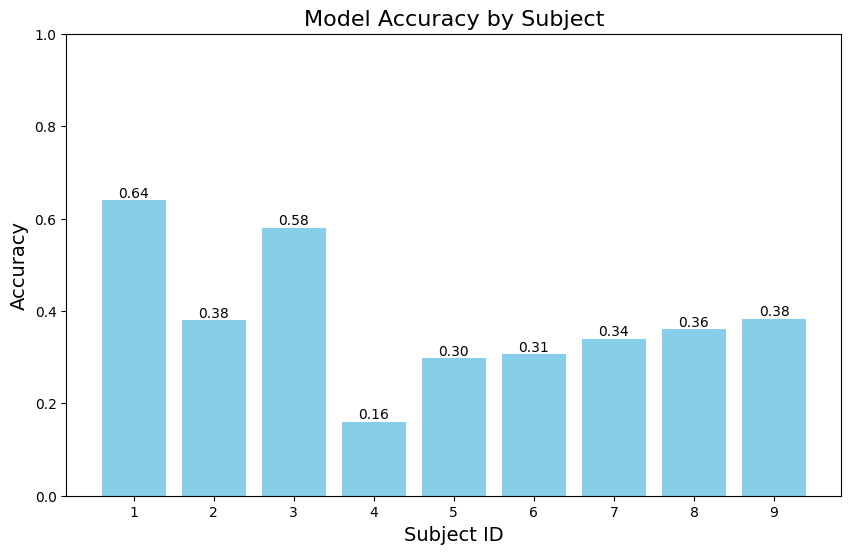

In [ ]:
evaluate_and_plot(hybrid_model_optimizeSub1, x_test_by_subject, y_test_by_subject)

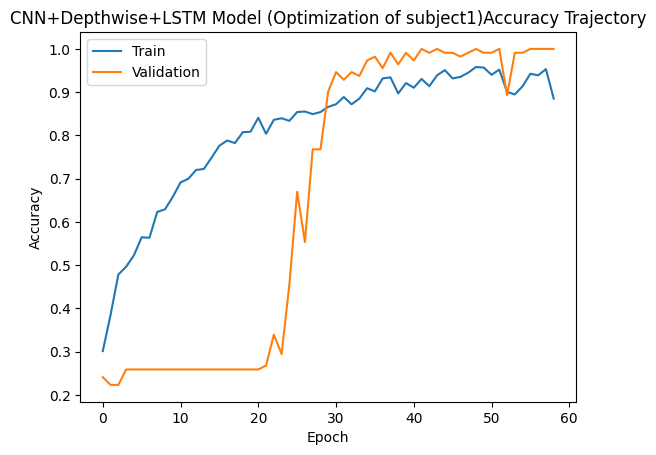

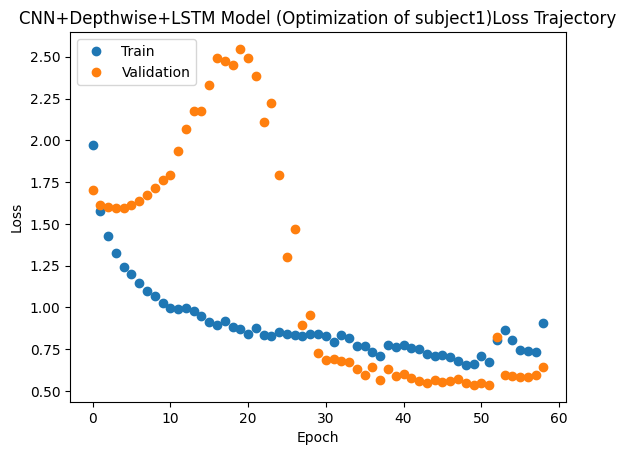

14/14 [==============================] - 0s 22ms/step - loss: 3.2075 - accuracy: 0.4041
Test Loss: 3.207455635070801
Test Accuracy: 0.4040631949901581


In [52]:
plt.plot(hybrid_model_optimizeSub1_results.history['accuracy'])
plt.plot(hybrid_model_optimizeSub1_results.history['val_accuracy'])
plt.title('CNN+Depthwise+LSTM Model (Optimization of subject1)Accuracy Trajectory')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_model_optimizeSub1_results.history['loss'], 'o')
plt.plot(hybrid_model_optimizeSub1_results.history['val_loss'], 'o')
plt.title('CNN+Depthwise+LSTM Model (Optimization of subject1)Loss Trajectory')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing the whole model
test_loss, test_accuracy = hybrid_model_optimizeSub1.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")